In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import h5py
import sys
import os
from numba import njit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = 'Computer Modern Roman'
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getopt
from itertools import zip_longest
import multiprocessing as mprocs
import time as TIME
from subprocess import Popen, PIPE
from matplotlib.pyplot import cm
from functions import tc, import_data, sim_data, import_data, import_spectra_data, import_post_processing_data, import_sys_msr, compute_pdf 

In [1]:
%connect_info

{
  "shell_port": 50781,
  "iopub_port": 48071,
  "stdin_port": 46863,
  "control_port": 44065,
  "hb_port": 51993,
  "ip": "127.0.0.1",
  "key": "d9f1fd0f-78c8ef4b404eced28c9b9047",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6cc6f33a-ec2d-4fd8-9424-c9a0e0fdb930.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [6]:
in_dir = "/home/enda/PhD/2D-Navier-Stokes/Data/ThesisData/SIM_DATA_NAVIER_AB4CN_FULL_N[256,256]_T[0.0,0.001,200.000]_NU[5e-15,1,4.0]_DRAG[0.1,0.1,1,0.0]_CFL[0.90]_FORC[BODY_FORC,2,1]_u0[RANDOM]_TAG[Small-Stats-Run]/"
out_dir = in_dir + "PHASE_ONLY_SNAPS/"

In [7]:
%%time
# -----------------------------------------
# # --------  Read In data
# -----------------------------------------
## Read in simulation parameters
sys_vars = sim_data(in_dir)

## Read in solver data
run_data = import_data(in_dir, sys_vars)

## Read in system measures data
sys_msr_data = import_sys_msr(in_dir, sys_vars)

## Read in spectra data
spec_data = import_spectra_data(in_dir, sys_vars)

## Read in post processing data
# post_data = import_post_processing_data(post_file_path, sys_vars, 'file')


Preparing real space vorticity from Solver Data... Finished!
CPU times: user 1.37 s, sys: 413 ms, total: 1.78 s
Wall time: 5.42 s


## Get time Averaged Amplitudes

In [8]:
%%time 
a_k_t_avg = np.zeros((sys_vars.Ny, sys_vars.Nx//2 + 1))
t_count = 0
for t in range(sys_vars.ndata):
    a_k_t_avg[:, :] += np.absolute(run_data.w_hat[t, :, :])
    t_count += 1
a_k_t_avg /= t_count

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 163 ms


## Construct the vorticity with the time averaged Amplitudes

In [9]:
%%time
w_hat_t_avg = np.zeros((sys_vars.ndata, sys_vars.Ny, sys_vars.Nx//2 + 1), dtype = "complex128")
for t in range(sys_vars.ndata):
    w_hat_t_avg[t, :, :] = a_k_t_avg[:, :] * np.exp(1j * np.angle(run_data.w_hat[t, :, :]))

CPU times: user 458 ms, sys: 89.3 ms, total: 548 ms
Wall time: 548 ms


## Define Stats Functions

In [18]:
@njit
def compute_w_str_func(field, in_powers = 6):
    ## Get dims
    Ny = field.shape[0]
    Nx = field.shape[1]
    
    ## Get increments
    r_inc = np.arange(1, Nx//2)
    
    ## Get powers
    if isinstance(in_powers, int):
        powers = np.arange(1, in_powers + 1)
    else:
        powers = in_powers
    
    ## Allocate memory
    str_func     = np.zeros((len(powers), len(r_inc), 2))
    str_func_abs = np.zeros((len(powers), len(r_inc), 2))
    
    for i, p in enumerate(powers):
        for j, r in enumerate(r_inc):
            
            ## Define increments
            long_incr      = 0.0
            trans_incr     = 0.0
            long_incr_abs  = 0.0
            trans_incr_abs = 0.0
    
            for ky in range(Ny):
                for kx in range(Nx):
                    ## Update increment sums
                    long_incr      += np.power(field[i, np.mod(j + r, Nx)] - field[i, j], p)
                    trans_incr     += np.power(field[np.mod(i + r, Ny), j] - field[i, j], p)
                    long_incr_abs  += np.power(field[i, np.mod(j + r, Nx)] - field[i, j], p)
                    trans_incr_abs += np.power(field[np.mod(i + r, Ny), j] - field[i, j], p)
            
            str_func[i, j, 0]     = long_incr
            str_func[i, j, 1]     = trans_incr
            str_func_abs[i, j, 0] = long_incr_abs
            str_func_abs[i, j, 1] = trans_incr_abs
    
    return str_func, str_func_abs

@njit
def compute_u_str_func(field, in_powers = 6):
    ## Get dims
    Ny = field.shape[0]
    Nx = field.shape[1]
    
    ## Get increments
    r_inc = np.arange(1, Nx//2)
    
    ## Get powers
    if isinstance(in_powers, int):
        powers = np.arange(1, in_powers + 1)
    else:
        powers = in_powers
    
    ## Allocate memory
    str_func     = np.zeros((len(powers), len(r_inc), 2))
    str_func_abs = np.zeros((len(powers), len(r_inc), 2))
    
    for i, p in enumerate(powers):
        for j, r in enumerate(r_inc):
            
            ## Define increments
            long_incr      = 0.0
            trans_incr     = 0.0
            long_incr_abs  = 0.0
            trans_incr_abs = 0.0
    
            for ky in range(Ny):
                for kx in range(Nx):
                    ## Update increment sums
                    long_incr      += np.power(field[i, np.mod(j + r, Nx), 0] - field[i, j, 0], p)
                    trans_incr     += np.power(field[i, np.mod(j + r, Nx), 1] - field[i, j, 1], p)
                    long_incr_abs  += np.power(field[i, np.mod(j + r, Nx), 0] - field[i, j, 0], p)
                    trans_incr_abs += np.power(field[i, np.mod(j + r, Nx), 1] - field[i, j, 1], p)
            
            str_func[i, j, 0]     = long_incr / (Nx * Ny)
            str_func[i, j, 1]     = trans_incr / (Nx * Ny)
            str_func_abs[i, j, 0] = long_incr_abs / (Nx * Ny)
            str_func_abs[i, j, 1] = trans_incr_abs / (Nx * Ny)
    
    return str_func, str_func_abs

## Compute Stats

In [20]:
%%time 
max_pow = 6
r_inc   = np.arange(1, sys_vars.Nx//2)

w_str_func     = np.zeros((max_pow, len(r_inc), 2))
w_str_func_abs = np.zeros((max_pow, len(r_inc), 2))
w_str_func_avg     = np.zeros((max_pow, len(r_inc), 2))
w_str_func_abs_avg = np.zeros((max_pow, len(r_inc), 2))

t_count = 0
for t in range(10):
    print(t)
    ## Get str function on solver data
    w_str_func_tmp, w_str_func_abs_tmp = compute_w_str_func(np.fft.irfft2(run_data.w_hat[t, :, :]), in_powers = max_pow)
    w_str_func     += w_str_func_tmp
    w_str_func_abs += w_str_func_tmp_abs
    
    ## Get str function on solver data
    w_str_func_tmp, w_str_func_abs_tmp = compute_w_str_func(np.fft.irfft2(w_hat_t_avg[t, :, :]), in_powers = max_pow)
    w_str_func_avg     += w_str_func_tmp
    w_str_func_abs_avg += w_str_func_tmp_abs
    
    ## Incremnt
    t_count += 1
    
## Normalize
w_str_func     /= t_count
w_str_func_abs /= t_count
w_str_func_avg     /= t_count
w_str_func_abs_avg /= t_count

0


NameError: name 'w_str_func_tmp_abs' is not defined

## Plot Data to Compare

In [9]:
N = 16
kx = np.arange(0, N//2 + 1)
ky = np.append(kx, np.arange(-N//2 + 1, 0, 1))


In [10]:
print(kx)
print(ky)

[0 1 2 3 4 5 6 7 8]
[ 0  1  2  3  4  5  6  7  8 -7 -6 -5 -4 -3 -2 -1]


In [82]:
kf = 7
delta = 0.5
forced = np.zeros((len(ky), len(kx)))
count = 0
for i in ky:
    for j in kx:
        # k_sqr = i**2 + j**2
        k_sqr = np.round(np.sqrt(i**2 + j**2))
        # if k_sqr <= (kf)**2 + delta and k_sqr >= (kf)**2 - delta:
        if k_sqr <= kf + delta and k_sqr >= kf - delta:
            forced[i, j] = 1.0
            print(i, j, k_sqr)
            count += 1

print(count)

0 7 7.0
1 7 7.0
2 7 7.0
3 6 7.0
4 6 7.0
5 5 7.0
6 3 7.0
6 4 7.0
7 0 7.0
7 1 7.0
7 2 7.0
-7 0 7.0
-7 1 7.0
-7 2 7.0
-6 3 7.0
-6 4 7.0
-5 5 7.0
-4 6 7.0
-3 6 7.0
-2 7 7.0
-1 7 7.0
21


In [80]:
for i in ky:
    for j in kx:
        print("[{},{}]: {} ".format(ky[i], kx[j], forced[i, j]), end = "")
    print()

[0,0]: 0.0 [0,1]: 0.0 [0,2]: 0.0 [0,3]: 0.0 [0,4]: 0.0 [0,5]: 0.0 [0,6]: 0.0 [0,7]: 1.0 [0,8]: 0.0 
[1,0]: 0.0 [1,1]: 0.0 [1,2]: 0.0 [1,3]: 0.0 [1,4]: 0.0 [1,5]: 0.0 [1,6]: 0.0 [1,7]: 1.0 [1,8]: 0.0 
[2,0]: 0.0 [2,1]: 0.0 [2,2]: 0.0 [2,3]: 0.0 [2,4]: 0.0 [2,5]: 0.0 [2,6]: 0.0 [2,7]: 1.0 [2,8]: 0.0 
[3,0]: 0.0 [3,1]: 0.0 [3,2]: 0.0 [3,3]: 0.0 [3,4]: 0.0 [3,5]: 0.0 [3,6]: 1.0 [3,7]: 0.0 [3,8]: 0.0 
[4,0]: 0.0 [4,1]: 0.0 [4,2]: 0.0 [4,3]: 0.0 [4,4]: 0.0 [4,5]: 0.0 [4,6]: 1.0 [4,7]: 0.0 [4,8]: 0.0 
[5,0]: 0.0 [5,1]: 0.0 [5,2]: 0.0 [5,3]: 0.0 [5,4]: 0.0 [5,5]: 1.0 [5,6]: 0.0 [5,7]: 0.0 [5,8]: 0.0 
[6,0]: 0.0 [6,1]: 0.0 [6,2]: 0.0 [6,3]: 1.0 [6,4]: 1.0 [6,5]: 0.0 [6,6]: 0.0 [6,7]: 0.0 [6,8]: 0.0 
[7,0]: 1.0 [7,1]: 1.0 [7,2]: 1.0 [7,3]: 0.0 [7,4]: 0.0 [7,5]: 0.0 [7,6]: 0.0 [7,7]: 0.0 [7,8]: 0.0 
[8,0]: 0.0 [8,1]: 0.0 [8,2]: 0.0 [8,3]: 0.0 [8,4]: 0.0 [8,5]: 0.0 [8,6]: 0.0 [8,7]: 0.0 [8,8]: 0.0 
[-7,0]: 1.0 [-7,1]: 1.0 [-7,2]: 1.0 [-7,3]: 0.0 [-7,4]: 0.0 [-7,5]: 0.0 [-7,6]: 0.0 [-7,7]: 0.0 [-7,

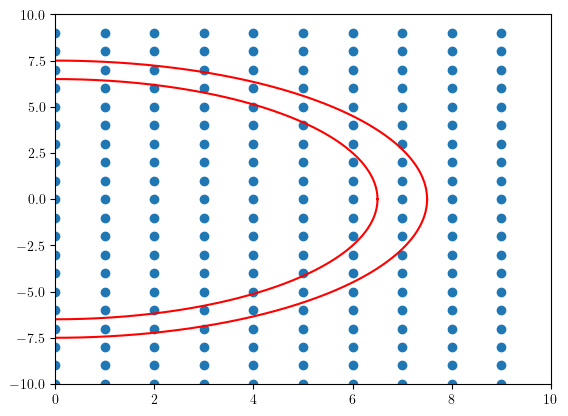

In [81]:
theta = np.arange(0, 2.0 * np.pi+ 2.0*np.pi/1000, 2.0*np.pi/1000)
xx, yy = np.meshgrid(np.arange(-10, 10), np.arange(-10, 10), indexing='ij')
plt.scatter(xx,yy)
plt.plot((kf - delta) * np.cos(theta), (kf - delta) * np.sin(theta), color = "red")
plt.plot((kf + delta) * np.cos(theta), (kf + delta) * np.sin(theta), color = "red")
plt.xlim(0, 10)
plt.ylim(-10, 10)
plt.show()